Project Task 2 - Advanced Classifiers and Evaluation

Using the dataset for classification prepared for Task 1 build several advanced classifiers able to predict room occupancy from the available variables. In particular, you are required to use SVM (linear and non-linear), NN (Single and Multilayer Perceptron), DNN (design at least two different architectures), Ensemble Classifier (RandomForest, AdaBoost and a Bagging technique in which you can select a base classifier of your choice with a justification).

 Evaluate each classifier using Accuracy, Precision, Recall, F1, ROC, etc; Draw your conclusion about the classifiers.
 
 Highlight in the report different aspects typical of each classifier. For instance for SVM: is a linear model the best way to shape the decision boundary? Or for NN: what are the parameter sets or the convergence criteria suggesting you are avoiding overfitting? How many iterations/base classifiers are needed to allow a good estimation using an ensemble method? Which is the feature importance for the Random Forest?
 
You are NOT required to experiment also in the imbalanced case but if you do it is not considered a mistake.


In [406]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

In [407]:
df = pd.read_csv('air_dataset.csv')
df.drop(columns='Unnamed: 0',inplace=True)
class_name = 'weekend'

In [408]:
df.head()

,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,weekend,PT08_feat
0,1.5,11.3,180.0,831.0,111.0,27.4,31.5,0,1186.50
1,2.0,13.0,310.0,971.0,129.0,35.0,17.3,0,1148.75
2,1.4,7.5,180.0,1114.0,119.0,24.9,28.3,0,1024.50
3,1.2,7.4,141.0,1088.0,98.0,23.2,30.5,0,1015.00
4,0.6,3.8,105.0,1254.0,89.0,22.3,33.6,0,883.25


In [409]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1, join_axes=[dfX.index])
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [410]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [411]:
class_name = 'weekend'

In [412]:
res = prepare_dataset(df, class_name)
df.head()

C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,weekend,PT08_feat
0,1.5,11.3,180.0,831.0,111.0,27.4,31.5,0,1186.50
1,2.0,13.0,310.0,971.0,129.0,35.0,17.3,0,1148.75
2,1.4,7.5,180.0,1114.0,119.0,24.9,28.3,0,1024.50
3,1.2,7.4,141.0,1088.0,98.0,23.2,30.5,0,1015.00
4,0.6,3.8,105.0,1254.0,89.0,22.3,33.6,0,883.25


# Data partitioning

In [413]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score, precision_score

In [414]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)


# Linear svm

In [415]:
from sklearn.svm import LinearSVC

In [416]:
clf = LinearSVC(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7126068376068376
Precision 0.0
Recall 0.0
F1-score [0.83218964 0.        ]
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1334
           1       0.00      0.00      0.00       538

    accuracy                           0.71      1872
   macro avg       0.36      0.50      0.42      1872
weighted avg       0.51      0.71      0.59      1872



C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Gridsearch

In [417]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

In [418]:
parameters = {'C': [0.1, 1, 10, 100, 1000]}

lsvc = LinearSVC()
search = GridSearchCV(lsvc, parameters,cv = 4)
search.fit(X_train, y_train)
report(search.cv_results_, n_top=3)

C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base

Model with rank: 1
Mean validation score: 0.713 (std: 0.000)
Parameters: {'C': 10}

Model with rank: 2
Mean validation score: 0.713 (std: 0.000)
Parameters: {'C': 0.1}

Model with rank: 2
Mean validation score: 0.713 (std: 0.000)
Parameters: {'C': 1}



C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [419]:
clf = search.best_estimator_
clf

LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [420]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7126068376068376
Precision 0.0
Recall 0.0
F1-score [0.83218964 0.        ]
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1334
           1       0.00      0.00      0.00       538

    accuracy                           0.71      1872
   macro avg       0.36      0.50      0.42      1872
weighted avg       0.51      0.71      0.59      1872



C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1334,    0],
       [ 538,    0]], dtype=int64)

In [421]:
accuracy = cross_val_score(clf, X, y, cv=5)
print('Accuracy:', np.mean(accuracy),accuracy)
print()
precision = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision')
print('Precision:', np.mean(precision), precision)
print()
recall = cross_val_score(clf, X_train, y_train, cv=5, scoring='recall')
print('Recall:', np.mean(recall),recall)
print()
f1_score = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')
print('F1-score:', np.mean(f1_score),f1_score)

C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.7114458422983276 [0.71153846 0.71260684 0.71298771 0.70764297 0.71245323]



C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to co

Precision: 0.0 [0. 0. 0. 0. 0.]



C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Recall: 0.0 [0. 0. 0. 0. 0.]



C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


F1-score: 0.41780850265505143 [0.4262831  0.41609482 0.41622465 0.4143975  0.41604245]


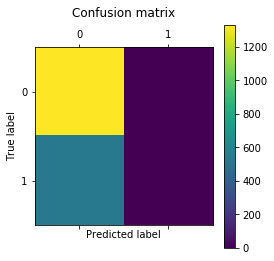

In [422]:
plt.matshow(cm)
plt.title('Confusion matrix\n')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [424]:
fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_pred, average=None)

0.5


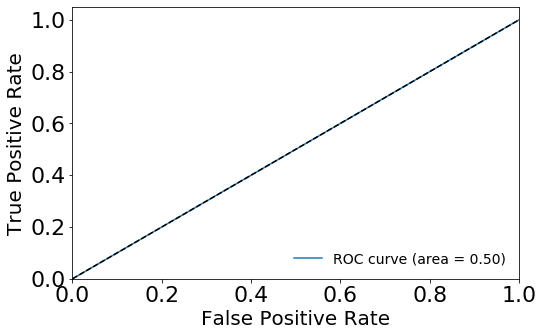

In [426]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

# BOH

In [385]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

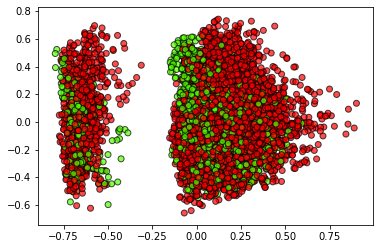

In [386]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [387]:
decision_function = clf.decision_function(X_train)
support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
support_vectors = X_train[support_vector_indices]

In [388]:
support_vectors_pca = pca.transform(support_vectors)

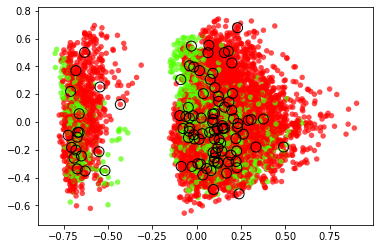

In [389]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

## Effect of C

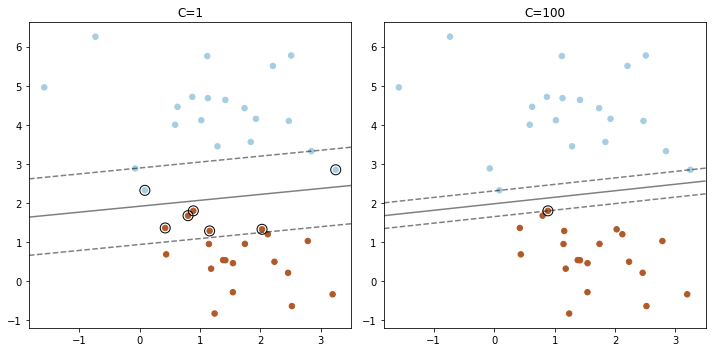

In [365]:
from sklearn.datasets import make_blobs
from sklearn.svm import LinearSVC

X, y = make_blobs(n_samples=40, centers=2, random_state=0)

plt.figure(figsize=(10, 5))
for i, C in enumerate([1, 100]):
    # "hinge" is the standard SVM loss
    clf = LinearSVC(C=C, loss="hinge", random_state=42).fit(X, y)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X)
    # we can also calculate the decision function manually
    # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
    support_vector_indices = np.where((2 * y - 1) * decision_function <= 1)[0]
    support_vectors = X[support_vector_indices]

    plt.subplot(1, 2, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
    plt.title("C=" + str(C))
plt.tight_layout()
plt.show()

# Nonlinear SVM

In [427]:
from sklearn.svm import SVC

In [428]:
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7126068376068376
Precision 0.0
Recall 0.0


C:\Users\bonin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TypeError: 'numpy.ndarray' object is not callable

### Gridsearch

In [430]:
parameters = {'C': np.arange(0.01,100,10), 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
svc = SVC()
search = GridSearchCV(svc, parameters,cv = 4)
search.fit(X_train, y_train)
report(search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.736 (std: 0.001)
Parameters: {'C': 90.01, 'gamma': 1, 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: 0.735 (std: 0.002)
Parameters: {'C': 80.01, 'gamma': 1, 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.734 (std: 0.002)
Parameters: {'C': 70.01, 'gamma': 1, 'kernel': 'rbf'}



In [432]:
clf = search.best_estimator_
clf

SVC(C=90.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [433]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7350427350427351
Precision 0.7333333333333333
Recall 0.12267657992565056


TypeError: 'numpy.ndarray' object is not callable

In [434]:
accuracy = cross_val_score(clf, X, y, cv=5)
print('Accuracy:', np.mean(accuracy),accuracy)
print()
precision = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision')
print('Precision:', np.mean(precision), precision)
print()
recall = cross_val_score(clf, X_train, y_train, cv=5, scoring='recall')
print('Recall:', np.mean(recall),recall)
print()
f1_score = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')
print('F1-score:', np.mean(f1_score),f1_score)

Accuracy: 0.7226663606006205 [0.73023504 0.72596154 0.72047034 0.71619455 0.72047034]

Precision: 0.7516486277691443 [0.76923077 0.75294118 0.64634146 0.86       0.72972973]

Recall: 0.1227906976744186 [0.11627907 0.14883721 0.12325581 0.1        0.1255814 ]

F1-score: 0.5161253985595073 [0.60946882 0.53097945 0.50649354 0.46205502 0.47163017]


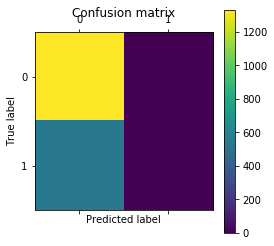

In [435]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [439]:
fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_pred, average=None)

0.5523427877139497


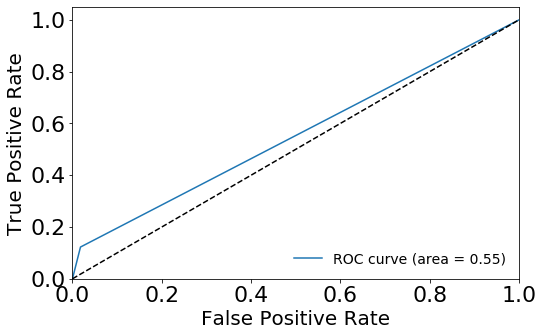

In [440]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

In [436]:
clf.support_

array([   2,    4,    5, ..., 7476, 7482, 7484])

In [437]:
clf.support_vectors_[:10]

array([[0.80263525, 0.18396226, 0.19118523, 0.21092757, 0.29881657,
        0.37419355, 0.52327044, 0.45364699],
       [0.75708954, 0.02672956, 0.14353782, 0.48538755, 0.18934911,
        0.29032258, 0.30691824, 0.14587973],
       [0.78745334, 0.14937107, 0.21679571, 0.21728081, 0.27810651,
        0.62150538, 0.23522013, 0.34535078],
       [0.80263525, 0.16194969, 0.30136986, 0.17069039, 0.34615385,
        0.39139785, 0.81383648, 0.38432628],
       [0.75492069, 0.04245283, 0.14353782, 0.34561626, 0.18343195,
        0.39569892, 0.51446541, 0.25250557],
       [0.        , 0.05188679, 0.        , 0.39135959, 0.16608235,
        0.45376344, 0.55220126, 0.23552339],
       [0.78311566, 0.08490566, 0.26265634, 0.23888183, 0.28994083,
        0.34623656, 0.78616352, 0.28994989],
       [0.75058301, 0.02987421, 0.13341275, 0.42524354, 0.10650888,
        0.48817204, 0.49433962, 0.19445991],
       [0.78311566, 0.10377358, 0.17629541, 0.23930538, 0.26923077,
        0.32903226, 0.759748

In [438]:
clf.n_support_, len(X_train)

(array([2119, 2054]), 7485)

## Effect of Different Kernels

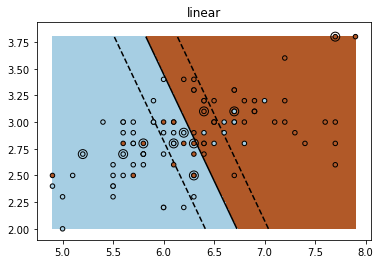

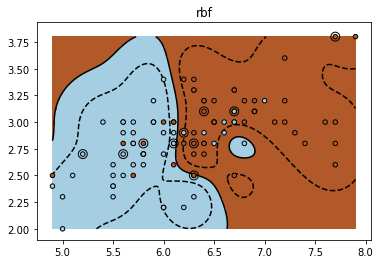

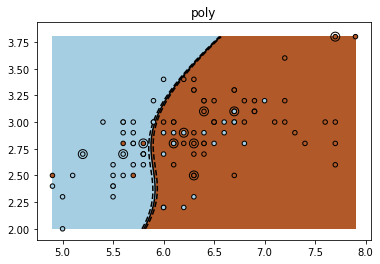

In [441]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

X = X[y != 0, :2]
y = y[y != 0]

n_sample = len(X)

np.random.seed(0)
order = np.random.permutation(n_sample)
X = X[order]
y = y[order].astype(np.float)

X_train = X[:int(.9 * n_sample)]
y_train = y[:int(.9 * n_sample)]
X_test = X[int(.9 * n_sample):]
y_test = y[int(.9 * n_sample):]

# fit the model
for kernel in ('linear', 'rbf', 'poly'):
    clf = SVC(kernel=kernel, gamma=10)
    clf.fit(X_train, y_train)

    plt.figure()
    plt.clf()
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired,
                edgecolor='k', s=20)

    # Circle out the test data
    plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none',
                zorder=10, edgecolor='k')

    plt.axis('tight')
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

    plt.title(kernel)
plt.show()